# Data Simulation using STAN
## Cole Polychronis
## Last Update: Mar 28, 2019

## (1) Generate Fake Data

In [60]:
# Import Libraries
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import CategoricalEncoder
import pystan
import math
import json

In [2]:
# Function to create a set of unique names from the name List
def select_names(num_needed):
    name_file = open("names.txt", "r")
    names = name_file.readlines()
    num_of_names = len(names)
    
    np.random.seed(1997)
    first_indices = np.random.choice(num_of_names, num_needed, replace=False)
    np.random.seed(2002)
    second_indices = np.random.choice(num_of_names, num_needed, replace=False)
    
    names = [(names[a][:-1],names[b][:-1]) for a,b in zip(first_indices, second_indices)]
    return names

In [3]:
# Nested dictionary structure to keep track of metadata for classess and assignments
# Contains mean and standard deviation for each assignment, as well as mean number and std dev of number of assignments logged
classes = {
    "Mathematics": {
        "Homework":{
            "mu": 60,
            "sd": 10,
            "num_avg": 15,
            "num_sd": 5
        },
        "Online_Activity":{
            "mu": 90,
            "sd": 15,
            "num_avg": 10,
            "num_sd": 5
        },
        "Reading":{
            "mu": 30,
            "sd": 5,
            "num_avg": 15,
            "num_sd": 5
        },
        "Takehome_Test":{
            "mu": 180,
            "sd": 30,
            "num_avg": 2,
            "num_sd": 1
        },
        "Study_Guide":{
            "mu": 120,
            "sd": 20,
            "num_avg": 2,
            "num_sd": 1
        },
        "Presentation":{
            "mu": 150,
            "sd": 20,
            "num_avg": 1,
            "num_sd": 1
        }   
    },
    "Language_&_Literature": {
         "Reading":{
            "mu": 60,
            "sd": 15,
            "num_avg": 15,
            "num_sd": 10
        },
        "Writing_Prompt":{
            "mu": 120,
            "sd": 30,
            "num_avg": 8,
            "num_sd": 3
        },
        "Essay":{
            "mu": 210,
            "sd": 40,
            "num_avg": 3,
            "num_sd": 2
        },
        "Presentation":{
            "mu": 90,
            "sd": 10,
            "num_avg": 1,
            "num_sd": 1
        }  
    },
    "Science": {
         "Homework":{
            "mu": 90,
            "sd": 20,
            "num_avg": 15,
            "num_sd": 5
        },
        "Lab":{
            "mu": 90,
            "sd": 20,
            "num_avg": 10,
            "num_sd": 2
        },
        "Reading":{
            "mu": 45,
            "sd": 10,
            "num_avg": 15,
            "num_sd": 5
        },
        "Takehome_Test":{
            "mu": 120,
            "sd": 20,
            "num_avg": 2,
            "num_sd": 1
        },
        "Study_Guide":{
            "mu": 120,
            "sd": 30,
            "num_avg": 2,
            "num_sd": 1
        },
        "Presentation":{
            "mu": 120,
            "sd": 20,
            "num_avg": 1,
            "num_sd": 1
        }
    },
    "Foreign_Language":{
        "Reading":{
            "mu": 75,
            "sd": 15,
            "num_avg": 15,
            "num_sd": 10
        },
        "Translation Activity":{
            "mu": 45,
            "sd": 10,
            "num_avg": 5,
            "num_sd": 3
        },
        "Homework":{
            "mu": 120,
            "sd": 15,
            "num_avg": 15,
            "num_sd": 1
        },
        "Interview":{
            "mu": 30,
            "sd": 5,
            "num_avg": 5,
            "num_sd": 1
        }
    },
    "Social_Studies":{
        "Homework":{
            "mu": 75,
            "sd": 15,
            "num_avg": 15,
            "num_sd": 10
        },
        "Reading":{
            "mu": 45,
            "sd": 5,
            "num_avg": 15,
            "num_sd": 10
        },
        "Essay":{
            "mu": 180,
            "sd": 30,
            "num_avg": 3,
            "num_sd": 2
        },
        "Presentation":{
            "mu": 120,
            "sd": 15,
            "num_avg": 1,
            "num_sd": 1
        }
    }
}

In [4]:
# Number of students we will generate data for
n = 20

In [5]:
# generates a random subset of classes that student is taking, 
# generates a distribution for the student pulled from the hyperpriors (classes dictionary)
np.random.seed(1997)
student_records = []

for student in select_names(n):
    for class_name in classes.keys():
        
        # selects random subset of classes student has taken
        taken = np.random.binomial(1, 0.9, len(classes[class_name].keys())) 
         
        for ind, assignment in enumerate(classes[class_name]):
            # if the class has been taken by the student (determined randomly)
            if taken[ind] == 1:
                assign = classes[class_name][assignment]
                num_entered = int(np.random.normal(assign["num_avg"], assign["num_sd"], 1))
                # checks if estimated value is negative, converts it to 0
                num_entered = num_entered if num_entered > 0 else 0 
                
                # generate distribution specific to student,
                # by pulling from hyperpriors to generate own normal model 
                mu = np.random.normal(assign["mu"], assign["sd"], 1)
                sd = np.random.exponential(assign["sd"], 1)
                
                student_entered_times = np.random.normal(mu, sd, num_entered)
                if len(student_entered_times) != 0:
                    for entry in student_entered_times:
                        record = []
                        record.append(student[0])
                        record.append(student[1])
                        record.append(class_name)
                        record.append(assignment)
                        record.append(abs(entry))
                        student_records.append(record)

In [6]:
# convert above 2d array into dataframe
df = pd.DataFrame(student_records)

In [7]:
# create the harder-easier categorical var
np.random.seed(1997)
hard_easy = np.random.choice(5, len(df), p=[0.1, 0.25, 0.3, 0.25, 0.1]).tolist()
hard_easy = [num+1 for num in hard_easy]

df[5] = hard_easy

In [8]:
# create the confidence categorical var
np.random.seed(3220)
confidence = np.random.choice(5, len(df), p=[0.1, 0.25, 0.3, 0.25, 0.1]).tolist()
confidence = [num+1 for num in confidence]

df[6] = confidence

In [9]:
# create space for actual time taken (response var)
df[7] = [0 for i in range(0, len(df))]

In [10]:
# add column names to dataframe
df.columns = ['first_name', 'last_name', 'class_type', 'assign_type', 'user_time_est', 'hard_easy', 'confidence', 'actual_time']

In [11]:
# break categorical variables into dummy variables
df = pd.get_dummies(df, columns=["class_type", "assign_type", "hard_easy", "confidence"])

In [12]:
# dictionary to contain actual population parameters
# ===================================================
# these are what the STAN model will try to estimate
# ===================================================

param_vals = [1.05, -100, 10, -7.5, 25, 15, -12, 30, 0.5, -5, 10, 12, 20, -5, 15, 27, 6, 4.5, -10, -5, 0, 8, 45, 12, 3, 0.05, -4, -30]

edu_params = {}
for index, param in enumerate(df.columns[2:]):
    if param != 'actual_time':
        edu_params[param]= param_vals[index]
        print param + ': ' + str(param_vals[index])

user_time_est: 1.05
class_type_Foreign_Language: 10
class_type_Language_&_Literature: -7.5
class_type_Mathematics: 25
class_type_Science: 15
class_type_Social_Studies: -12
assign_type_Essay: 30
assign_type_Homework: 0.5
assign_type_Interview: -5
assign_type_Lab: 10
assign_type_Online_Activity: 12
assign_type_Presentation: 20
assign_type_Reading: -5
assign_type_Study_Guide: 15
assign_type_Takehome_Test: 27
assign_type_Translation Activity: 6
assign_type_Writing_Prompt: 4.5
hard_easy_1: -10
hard_easy_2: -5
hard_easy_3: 0
hard_easy_4: 8
hard_easy_5: 45
confidence_1: 12
confidence_2: 3
confidence_3: 0.05
confidence_4: -4
confidence_5: -30


In [13]:
# create response variables - the "actual" amount of time it takes to complete an given assignment
response = np.zeros(len(df))
for key in edu_params.keys():
    tmp = [val*edu_params[key] for val in df[key]]
    response += tmp
response = np.absolute(response) #convert negative numbers to 0
df['actual_time'] = response

In [14]:
# introduce natural variability
sigma = 10
df['actual_time'] = np.random.normal(df['actual_time'], sigma)

In [15]:
# admire our work of creating a df
df.head()

,first_name,last_name,user_time_est,actual_time,class_type_Foreign_Language,class_type_Language_&_Literature,class_type_Mathematics,class_type_Science,class_type_Social_Studies,assign_type_Essay,...,hard_easy_1,hard_easy_2,hard_easy_3,hard_easy_4,hard_easy_5,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5
0,Fatoumatta,Valdemir,214.530091,254.309126,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,Fatoumatta,Valdemir,212.106636,249.134827,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,Fatoumatta,Valdemir,214.767269,270.041819,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,Fatoumatta,Valdemir,65.634517,85.859798,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,Fatoumatta,Valdemir,36.462795,60.846007,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## (2) Visualize Data & Perform Necessary Transformations

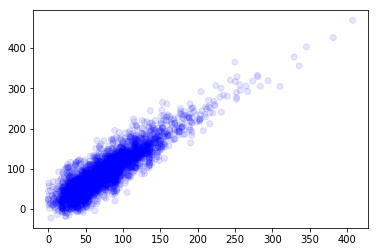

In [16]:
# visualize predicted time vs. actual time (constructed to be strongest relationship)
x = df['user_time_est']
y = df['actual_time']
colors = ['blue']*len(df)
plt.scatter(x,y, c=colors, alpha=0.1)
plt.show()

## (3) Stan Modeling

In [17]:
model= """
data {
    int<lower=0> J;
    int<lower=0> N;
    int<lower=0> K;
    int<lower=0, upper=J> students[N];
    matrix[N,K] X;
    vector[N] y;
}
parameters {
    vector[J] groupPred;
    vector[K] beta;
    real mu_a;
    real<lower=0> sigma_a;
    real<lower=0> sigma_y;
}
model {
    mu_a ~ normal(0, 15);
    groupPred ~ normal(mu_a, sigma_a);
    y ~ normal(X*beta + groupPred[students], sigma_y);
}
"""

In [18]:
# split data into testing and training set
train = df.sample(frac=0.8, random_state=1997)
test = df.drop(train.index)

In [19]:
# create stud dictionary, which keeps track of which rows belong to which student for train
studentNames_train = train.first_name.unique()
student_lookup_train = dict(zip(studentNames_train, range(len(train))))
stud_train = train.first_name.replace(student_lookup_train).values

In [20]:
# create stud dictionary, which keeps track of which rows belong to which student for test
studentNames_test = test.first_name.unique()
student_lookup_test = dict(zip(studentNames_test, range(len(test))))
stud_test = test.first_name.replace(student_lookup_test).values

In [21]:
# drop data that won't be used to model actual time (train)
train2 = train.drop('first_name', axis=1).drop('last_name', axis=1)
response_train = train['actual_time']
train2 = train2.drop('actual_time', axis=1)

In [22]:
# drop data that won't be used to model actual time (test)
test2 = test.drop('first_name', axis=1).drop('last_name', axis=1)
response_test = test['actual_time']
test2 = test2.drop('actual_time', axis=1)

In [23]:
# create data matrix and response variable for training data
train2_mat = pd.DataFrame.as_matrix(train2)
response_train = list(response_train)

/Users/colepolychronis/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [24]:
data = {
    'J': len(studentNames_train),
    'N': len(train2),
    'K':len(train2.columns),
    'students': stud_train+1,
    'X': train2_mat,
    'y': response_train
}

In [25]:
# Compile the model
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ba2bb022771246da8b271d047e56c48b NOW.


In [26]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=2, warmup=100, seed=101)

In [27]:
print(fit)

Inference for Stan model: anon_model_ba2bb022771246da8b271d047e56c48b.
2 chains, each with iter=1000; warmup=100; thin=1; 
post-warmup draws per chain=900, total post-warmup draws=1800.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
groupPred[1]    5.94    1.64   2.37    1.1   4.58   6.16   7.61  10.13    2.0    1.6
groupPred[2]    6.28    1.65   2.41   1.44   4.83   6.44   8.02  10.51    2.0   1.59
groupPred[3]     6.0    1.65   2.38    1.0   4.67   6.23   7.63  10.11    2.0    1.6
groupPred[4]    5.62    1.61   2.34   0.75   4.27   5.92   7.17   9.74    2.0   1.59
groupPred[5]    5.89    1.62   2.35   1.05   4.59    6.1   7.51  10.02    2.0   1.61
groupPred[6]    6.08    1.64   2.37   1.21   4.68   6.31   7.72  10.14    2.0    1.6
groupPred[7]     6.1    1.63   2.39   1.16   4.74   6.33   7.72  10.35    2.0   1.59
groupPred[8]    6.25    1.64   2.39   1.35   4.85   6.47   7.89  10.29    2.0   1.59
groupPred[9]    6.08    1.64   2.39   1.15   4.6

In [28]:
# extract group predictors and model parameters
params = []
for row in fit.get_posterior_mean():
    params.append(sum(row)/len(row))
group_predictor = params[:20]
params = params[20:-4]

In [29]:
# calculate train MSE
MSE = 0
for row, y, pred_level in zip(train2_mat, response_train, stud_train):
    yhat = 0
    for ind, cell in enumerate(row):
        yhat += row[ind]*params[ind]
    yhat += group_predictor[pred_level]
    MSE += math.pow(yhat-y, 2)
MSE = math.sqrt(MSE/len(train2_mat))

### Training RMSE

In [30]:
MSE

10.25933219979613

In [31]:
# create data matrix and response variable for training data
test2_mat = pd.DataFrame.as_matrix(test2)
response_test = list(response_test)

/Users/colepolychronis/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [32]:
# calculate test MSE
testMSE = 0
for row, y, pred_level in zip(test2_mat, response_test, stud_test):
    yhat = 0
    for ind, cell in enumerate(row):
        yhat += row[ind]*params[ind]
    yhat += group_predictor[pred_level]
    testMSE += math.pow(yhat-y, 2)
testMSE = math.sqrt(testMSE/len(train2_mat))

### Testing MSE

In [33]:
testMSE

5.33397647298352

## Create Model params to be Passed to Python

In [52]:
# extract parameter estimated from fit
params = []
for row in fit.get_posterior_mean():
    params.append(sum(row)/len(row))
params = params[20:-4]

In [53]:
params

[1.0407846429649097,
 3.4917130235780287,
 -13.781121848998678,
 16.634073266654735,
 7.410929806289198,
 -19.650988233711956,
 24.944355390940082,
 -5.86001970692884,
 -9.798188701705808,
 3.819233089960673,
 7.4387181172579595,
 14.986051332802461,
 -11.418482602382063,
 12.54832543908372,
 20.578251151878703,
 -3.491509295559495,
 -3.2448264758081335,
 -7.712202719773648,
 -2.6531629274854582,
 2.283180225037981,
 9.108415699463475,
 46.55812703480338,
 18.05456767423082,
 8.809491265510083,
 5.869487463999799,
 2.8398695747062495,
 -21.636031508872136]

In [57]:
# create a dictionary with parameter name and estimate - which we convert to JSON
edu_params_estimate = {}
for index, param in enumerate(df.drop('actual_time', axis=1).columns[2:]):
    edu_params_estimate[param]= params[index]

In [63]:
# add group predictors to dictionary
groupPreds = []
for row in fit.get_posterior_mean():
    groupPreds.append(sum(row)/len(row))
groupPreds = groupPreds[:20]

for index, pred in enumerate(groupPreds):
    edu_params_estimate['groupPred_' + str(index)] = pred

In [64]:
edu_params_estimate

{'assign_type_Essay': 24.944355390940082,
 'assign_type_Homework': -5.86001970692884,
 'assign_type_Interview': -9.798188701705808,
 'assign_type_Lab': 3.819233089960673,
 'assign_type_Online_Activity': 7.4387181172579595,
 'assign_type_Presentation': 14.986051332802461,
 'assign_type_Reading': -11.418482602382063,
 'assign_type_Study_Guide': 12.54832543908372,
 'assign_type_Takehome_Test': 20.578251151878703,
 'assign_type_Translation Activity': -3.491509295559495,
 'assign_type_Writing_Prompt': -3.2448264758081335,
 'class_type_Foreign_Language': 3.4917130235780287,
 'class_type_Language_&_Literature': -13.781121848998678,
 'class_type_Mathematics': 16.634073266654735,
 'class_type_Science': 7.410929806289198,
 'class_type_Social_Studies': -19.650988233711956,
 'confidence_1': 18.05456767423082,
 'confidence_2': 8.809491265510083,
 'confidence_3': 5.869487463999799,
 'confidence_4': 2.8398695747062495,
 'confidence_5': -21.636031508872136,
 'groupPred_0': 5.944613943181594,
 'groupPr

In [66]:
with open('model_params.json', 'wb') as js:
    json.dump(edu_params_estimate, js)